In [1]:
import rebound
from DynamicalSim import *
from imports import *
from read_data import *
from rvmodel import get_rv1
%matplotlib inline


Bad key "xtick.labeltop" on line 358 in
/Users/ryancloutier/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [170]:
# define L 98-59 system params
Ms, Rs = .3124, .3137
Ps, T0s, mps, incps, eccps = initialize_system_parameters()
Ps = {'b':2.2531, 'c':3.6904, 'd':7.4512}
T0s = {'b':2458366.1708, 'c':2458367.2752, 'd':2458362.7376}
mps['b'], mps['c'], mps['d'] = .3, 2., 2.3  # forecaster values from Kostov+2019
incps['b'], incps['c'], incps['d'] = float(rvs.inclination(Ps['b'], Ms, Rs, .32)), \
                                     float(rvs.inclination(Ps['c'], Ms, Rs, .24)), \
                                     float(rvs.inclination(Ps['d'], Ms, Rs, .87))  # impact params from Kostov+2019
eccps['b'], eccps['c'], eccps['d'] = 2e-4, 2e-4, 2e-4

In [171]:
# get window function
bjdH, rv = read_HARPS()[:2]
badRVs = np.array([48])
g = np.delete(np.arange(bjdH.size), badRVs)
bjdH, rv = bjdH[g], rv[g]

# add early point to start the integration
bjdH = np.append(np.append(bjdH-500, bjdH), bjdH+500)

print bjdH.size

-5678.16
339


## run N-body simulation

In [172]:
# Initialize simulation
sim = rebound.Simulation()
sim.integrator = "whfast"
sim.units = ('AU','Msun','yr')

sim.add(m=Ms, hash='star')

# add planets
h, k = {}, {}
for p in Ps.keys():
#for p in ['d']:
    mp = rvs.kg2Msun(rvs.Mearth2kg(mps[p]))
    Pp = Ps[p]
    ap = rvs.semimajoraxis(Pp, Ms, 0)
    thetap = 2*np.pi * foldAt(bjdH.min(), Pp, T0s[p]) - np.pi/2
    eccp, omegap, incp = eccps[p], np.pi/2, np.deg2rad(incps[p])
    h[p] = np.sqrt(eccp)*np.cos(omegap)
    k[p] = np.sqrt(eccp)*np.sin(omegap)
    Omegap = 0.#np.random.uniform(0,2*np.pi)
    sim.add(m=mp, a=ap, inc=incp, e=eccp, omega=omegap, Omega=Omegap, theta=thetap, hash=p)
    
sim.move_to_com()

In [173]:
# run N-body integration
#times = rvs.days2yrs(bjdH-bjdH.min())
times = rvs.days2yrs(np.linspace(0, bjdH.max()-bjdH.min(), 10000))

# Save output
nparticles = len(sim.particles.keys())
RV_Nbody_fine = np.zeros(times.size)
stable = True
smas, eccs, incs = np.zeros((times.size, nparticles-1)), \
                   np.zeros((times.size, nparticles-1)), \
                   np.zeros((times.size, nparticles-1))
dist = np.zeros(times.size)
ps = sim.particles
try:
    for i in range(times.size):
        sim.integrate(times[i])
        #dp = ps[1]-ps[2]
        #dist[i] = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
        RV_Nbody_fine[i] = sim.particles['star'].vz
        for j in range(nparticles-1):
            smas[i,j] = sim.particles[j+1].a  # AU
            eccs[i,j] = sim.particles[j+1].e
            incs[i,j] = np.rad2deg(sim.particles[j+1].inc)
except rebound.Encounter as error:
    stable = False
    
# Convert units (AU/yr -> m/s)
RV_Nbody_fine = rvs.AU2m(RV_Nbody_fine) / (365.25*24*60*60)

# interpolate the integration to the WF
fint = interp1d(rvs.yrs2days(times)+bjdH.min(), RV_Nbody_fine)
RV_Nbody = fint(bjdH)

## compute superposition of keplerians

In [174]:
# get keplerian RV curve
keps = np.zeros((bjdH.size,3))
keps_fine = np.zeros((times.size,3))
ind = 0
for p in Ps.keys():
#for p in ['d']:
    Kp = rvs.RV_K(Ps[p], Ms, mps[p], inc_deg=incps[p], ecc=eccps[p])
    theta = Ps[p], T0s[p], 0, Kp, h[p], k[p]
    print theta
    keps[:,ind] = get_rv1(theta, bjdH)
    keps_fine[:,ind] = get_rv1(theta, rvs.yrs2days(times)+bjdH.min())
    ind += 1
    
RV_kep = np.sum(keps, axis=1)
RV_kep_fine = np.sum(keps_fine, axis=1)

(3.6904, 2458367.2752, 0, 1.7970507973904624, 8.659560562354933e-19, 0.01414213562373095)
(2.2531, 2458366.1708, 0, 0.3177007285854297, 8.659560562354933e-19, 0.01414213562373095)
(7.4512, 2458362.7376, 0, 1.6346724628008078, 8.659560562354933e-19, 0.01414213562373095)


(2.5, 2.8)

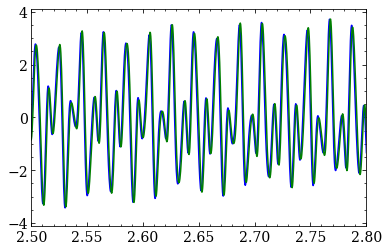

In [175]:
plt.plot(times, RV_Nbody_fine, '-')
plt.plot(times, RV_kep_fine, '-')
plt.xlim((2.5,2.8))

## compare RV curves

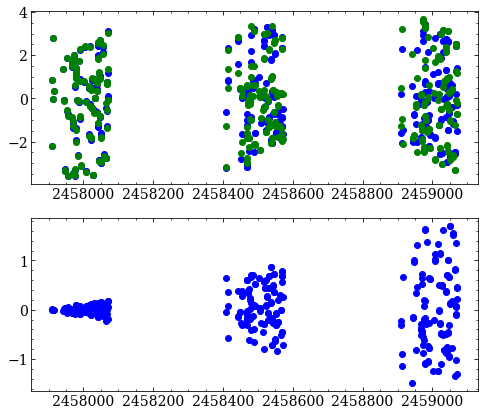

In [176]:
plt.figure(figsize=(8,7))
plt.subplot(211)
plt.plot(bjdH, RV_Nbody, 'o')
plt.plot(bjdH, RV_kep, 'o')

plt.subplot(212)
plt.plot(bjdH, RV_Nbody-RV_kep, 'o')

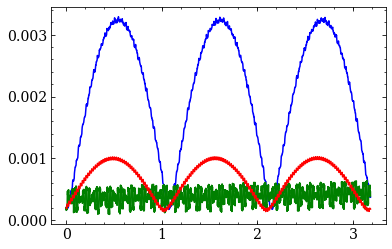

In [178]:
plt.plot(times, eccs)

In [179]:
Ps

{'b': 2.2531, 'c': 3.6904, 'd': 7.4512}